In [ ]:
#!pip install timm
#!pip install ipywidgets
#!pip install optuna plotly
#!pip install kaleido

# new model - coatnet
hybrid architecture - Convolution + Attention.

In [ ]:
import torch
import optuna
import evaluate
import sys
import shutil
import safetensors.torch
import numpy as np
import timm
import matplotlib.pyplot as plt
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances
from optuna.visualization import plot_optimization_history, plot_param_importances
from datasets import load_from_disk
from transformers import TrainingArguments, Trainer, set_seed
from torchvision.transforms import (
    Compose, Resize, CenterCrop, ToTensor, Normalize, 
    RandomHorizontalFlip, RandomResizedCrop
)

DATA_PATH = "processed_bird_data"
OUTPUT_DIR = "new_model_checkpoints"
MODEL_NAME = "coatnet_0_rw_224"

if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using device: {device}")

print("Loading and transforming data.")
dataset = load_from_disk(DATA_PATH)

Using device: mps
Loading and transforming data.


Applying Aggressive Data Augmentation to prevent overfitting:

1. Does random resize/zoom (scale 0.8–1.0). Forces the model to recognize a bird by looking at its specific feature (e.g. the head, wing, etc.) instead of the background (e.g. tress).
2. Incorporates horizontal flipping to double the training data.

In [3]:
normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

_train_transforms = Compose([
    RandomResizedCrop(224, scale=(0.8, 1.0)), 
    RandomHorizontalFlip(),
    ToTensor(),
    normalize,
])

_val_transforms = Compose([
    Resize(256),
    CenterCrop(224),
    ToTensor(),
    normalize,
])

def train_transforms(batch):
    batch["pixel_values"] = [_train_transforms(image.convert("RGB")) for image in batch["image"]]
    return batch

def val_transforms(batch):
    batch["pixel_values"] = [_val_transforms(image.convert("RGB")) for image in batch["image"]]
    return batch

# fix nonetype error
dataset["train"] = dataset["train"].map(
    train_transforms, batched=True, remove_columns=["image"]
)
dataset["validation"] = dataset["validation"].map(
    val_transforms, batched=True, remove_columns=["image"]
)

print("Data ready.")

Data ready.


# Training
Initializing CoAtNet model with random weights, no pretraining. 

It uses standard Convolutional layers in the early stages to extract low-level features (edges, textures), and then uses Transformer layers in the final stages to understand the global shape of the bird. Using Bayesian optimisation.

In [4]:
accuracy = evaluate.load("accuracy")

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return accuracy.compute(predictions=preds, references=p.label_ids)

class TimmTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        pixel_values = inputs.get("pixel_values")
        labels = inputs.get("labels")
        logits = model(pixel_values)
        loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(logits, labels)
        return (loss, logits) if return_outputs else loss
    
    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
        pixel_values = inputs.get("pixel_values")
        labels = inputs.get("labels")
        with torch.no_grad():
            logits = model(pixel_values)
        loss = None
        if labels is not None:
            loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
        return (loss, logits, labels)

# bayesian optimization with optuna
def objective(trial):
    # hyperparameters
    learning_rate = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-4, 1e-1, log=True)
    
    model = timm.create_model(MODEL_NAME, pretrained=False, num_classes=200)
    model.to(device)
    
    run_args = TrainingArguments(
        output_dir=f"{OUTPUT_DIR}/trial_{trial.number}", 
        per_device_train_batch_size=32, 
        num_train_epochs=5,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        warmup_ratio=0.1,
        disable_tqdm=True,
        logging_strategy="epoch",
        save_strategy="no",
        eval_strategy="epoch",
        dataloader_num_workers=0,
        remove_unused_columns=False,
        report_to="none"
    )
    
    trainer = TimmTrainer(
        model=model,
        args=run_args,
        train_dataset=dataset["train"],
        eval_dataset=dataset["validation"],
        compute_metrics=compute_metrics,
    )
    
    trainer.train()
    
    metrics = trainer.evaluate()
    accuracy = metrics["eval_accuracy"]
    
    trial.report(accuracy, step=5)
    if trial.should_prune():
        raise optuna.TrialPruned()
        
    return accuracy

print("starting optimization.")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("\n" + "="*40)
print(f"Best accuracy: {study.best_value*100:.2f}%")
print(f"Best learning rate: {study.best_params['lr']:.6f}")
print(f"Best weight decay: {study.best_params['weight_decay']:.6f}")
print("="*40)

[I 2025-12-13 00:14:53,795] A new study created in memory with name: no-name-d78dbc17-a704-40ad-b711-2479d1a99134


starting optimization.


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 5.2425, 'grad_norm': 11.513040542602539, 'learning_rate': 2.8994837191926922e-05, 'epoch': 1.0}
{'eval_loss': 5.110533714294434, 'eval_accuracy': 0.015280135823429542, 'eval_runtime': 51.7044, 'eval_samples_per_second': 11.392, 'eval_steps_per_second': 1.431, 'epoch': 1.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 4.8755, 'grad_norm': 12.688076972961426, 'learning_rate': 2.17633457307575e-05, 'epoch': 2.0}
{'eval_loss': 4.95403528213501, 'eval_accuracy': 0.03904923599320883, 'eval_runtime': 50.409, 'eval_samples_per_second': 11.684, 'eval_steps_per_second': 1.468, 'epoch': 2.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 4.6496, 'grad_norm': 14.168149948120117, 'learning_rate': 1.4531854269588076e-05, 'epoch': 3.0}
{'eval_loss': 4.848221302032471, 'eval_accuracy': 0.04584040747028863, 'eval_runtime': 50.8844, 'eval_samples_per_second': 11.575, 'eval_steps_per_second': 1.454, 'epoch': 3.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 4.4763, 'grad_norm': 15.0447416305542, 'learning_rate': 7.3003628084186556e-06, 'epoch': 4.0}
{'eval_loss': 4.792064189910889, 'eval_accuracy': 0.05432937181663837, 'eval_runtime': 50.7008, 'eval_samples_per_second': 11.617, 'eval_steps_per_second': 1.46, 'epoch': 4.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 4.369, 'grad_norm': 15.150389671325684, 'learning_rate': 6.88713472492326e-08, 'epoch': 5.0}
{'eval_loss': 4.775396347045898, 'eval_accuracy': 0.05602716468590832, 'eval_runtime': 49.7514, 'eval_samples_per_second': 11.839, 'eval_steps_per_second': 1.487, 'epoch': 5.0}
{'train_runtime': 2243.7132, 'train_samples_per_second': 7.436, 'train_steps_per_second': 0.234, 'train_loss': 4.72258062453497, 'epoch': 5.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
[I 2025-12-13 00:53:08,847] Trial 0 finished with value: 0.05602716468590832 and parameters: {'lr': 3.2507275901637785e-05, 'weight_decay': 0.00819586286364869}. Best is trial 0 with value: 0.05602716468590832.


{'eval_loss': 4.775396347045898, 'eval_accuracy': 0.05602716468590832, 'eval_runtime': 50.8297, 'eval_samples_per_second': 11.588, 'eval_steps_per_second': 1.456, 'epoch': 5.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 5.2839, 'grad_norm': 7.288018703460693, 'learning_rate': 0.000524728714543677, 'epoch': 1.0}
{'eval_loss': 5.175487995147705, 'eval_accuracy': 0.011884550084889643, 'eval_runtime': 52.4591, 'eval_samples_per_second': 11.228, 'eval_steps_per_second': 1.411, 'epoch': 1.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 4.8622, 'grad_norm': 6.568967342376709, 'learning_rate': 0.000393858132531596, 'epoch': 2.0}
{'eval_loss': 4.743896961212158, 'eval_accuracy': 0.03735144312393888, 'eval_runtime': 50.492, 'eval_samples_per_second': 11.665, 'eval_steps_per_second': 1.466, 'epoch': 2.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 4.4379, 'grad_norm': 8.712620735168457, 'learning_rate': 0.000262987550519515, 'epoch': 3.0}
{'eval_loss': 4.489076614379883, 'eval_accuracy': 0.0730050933786078, 'eval_runtime': 50.0676, 'eval_samples_per_second': 11.764, 'eval_steps_per_second': 1.478, 'epoch': 3.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 4.0204, 'grad_norm': 10.081070899963379, 'learning_rate': 0.0001321169685074341, 'epoch': 4.0}
{'eval_loss': 4.24075174331665, 'eval_accuracy': 0.0730050933786078, 'eval_runtime': 50.788, 'eval_samples_per_second': 11.597, 'eval_steps_per_second': 1.457, 'epoch': 4.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 3.6804, 'grad_norm': 12.151529312133789, 'learning_rate': 1.2463864953531518e-06, 'epoch': 5.0}
{'eval_loss': 4.113521575927734, 'eval_accuracy': 0.0967741935483871, 'eval_runtime': 51.1191, 'eval_samples_per_second': 11.522, 'eval_steps_per_second': 1.448, 'epoch': 5.0}
{'train_runtime': 2222.0846, 'train_samples_per_second': 7.509, 'train_steps_per_second': 0.236, 'train_loss': 4.4569436500186015, 'epoch': 5.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
[I 2025-12-13 01:31:00,961] Trial 1 finished with value: 0.0967741935483871 and parameters: {'lr': 0.0005882944258066877, 'weight_decay': 0.06440531064566528}. Best is trial 1 with value: 0.0967741935483871.


{'eval_loss': 4.113521575927734, 'eval_accuracy': 0.0967741935483871, 'eval_runtime': 49.2007, 'eval_samples_per_second': 11.971, 'eval_steps_per_second': 1.504, 'epoch': 5.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 5.2323, 'grad_norm': 11.302532196044922, 'learning_rate': 3.3822391978716245e-05, 'epoch': 1.0}
{'eval_loss': 5.105463981628418, 'eval_accuracy': 0.01697792869269949, 'eval_runtime': 51.2153, 'eval_samples_per_second': 11.5, 'eval_steps_per_second': 1.445, 'epoch': 1.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 4.8834, 'grad_norm': 12.119502067565918, 'learning_rate': 2.538687853984402e-05, 'epoch': 2.0}
{'eval_loss': 4.975046157836914, 'eval_accuracy': 0.035653650254668934, 'eval_runtime': 49.6144, 'eval_samples_per_second': 11.872, 'eval_steps_per_second': 1.492, 'epoch': 2.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 4.6507, 'grad_norm': 13.61575984954834, 'learning_rate': 1.69513651009718e-05, 'epoch': 3.0}
{'eval_loss': 4.849087715148926, 'eval_accuracy': 0.04753820033955857, 'eval_runtime': 50.4508, 'eval_samples_per_second': 11.675, 'eval_steps_per_second': 1.467, 'epoch': 3.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 4.4693, 'grad_norm': 13.890074729919434, 'learning_rate': 8.515851662099578e-06, 'epoch': 4.0}
{'eval_loss': 4.793532371520996, 'eval_accuracy': 0.04753820033955857, 'eval_runtime': 41.106, 'eval_samples_per_second': 14.329, 'eval_steps_per_second': 1.8, 'epoch': 4.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 4.3453, 'grad_norm': 14.889199256896973, 'learning_rate': 8.03382232273545e-08, 'epoch': 5.0}
{'eval_loss': 4.760318279266357, 'eval_accuracy': 0.05602716468590832, 'eval_runtime': 41.2497, 'eval_samples_per_second': 14.279, 'eval_steps_per_second': 1.794, 'epoch': 5.0}
{'train_runtime': 2103.5144, 'train_samples_per_second': 7.932, 'train_steps_per_second': 0.25, 'train_loss': 4.716188151041667, 'epoch': 5.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
[I 2025-12-13 02:06:44,700] Trial 2 finished with value: 0.05602716468590832 and parameters: {'lr': 3.7919641363311324e-05, 'weight_decay': 0.006816467600356044}. Best is trial 1 with value: 0.0967741935483871.


{'eval_loss': 4.760318279266357, 'eval_accuracy': 0.05602716468590832, 'eval_runtime': 39.2737, 'eval_samples_per_second': 14.997, 'eval_steps_per_second': 1.884, 'epoch': 5.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 5.2492, 'grad_norm': 11.673582077026367, 'learning_rate': 2.5004078948896126e-05, 'epoch': 1.0}
{'eval_loss': 5.128129482269287, 'eval_accuracy': 0.013582342954159592, 'eval_runtime': 40.7427, 'eval_samples_per_second': 14.457, 'eval_steps_per_second': 1.816, 'epoch': 1.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 4.9196, 'grad_norm': 12.197758674621582, 'learning_rate': 1.8767907239551488e-05, 'epoch': 2.0}
{'eval_loss': 5.014156818389893, 'eval_accuracy': 0.03225806451612903, 'eval_runtime': 40.5498, 'eval_samples_per_second': 14.525, 'eval_steps_per_second': 1.825, 'epoch': 2.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 4.7159, 'grad_norm': 13.201201438903809, 'learning_rate': 1.2531735530206846e-05, 'epoch': 3.0}
{'eval_loss': 4.912810802459717, 'eval_accuracy': 0.04584040747028863, 'eval_runtime': 43.0977, 'eval_samples_per_second': 13.667, 'eval_steps_per_second': 1.717, 'epoch': 3.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 4.5697, 'grad_norm': 13.703865051269531, 'learning_rate': 6.2955638208622075e-06, 'epoch': 4.0}
{'eval_loss': 4.868636608123779, 'eval_accuracy': 0.044142614601018676, 'eval_runtime': 40.9062, 'eval_samples_per_second': 14.399, 'eval_steps_per_second': 1.809, 'epoch': 4.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 4.47, 'grad_norm': 14.587310791015625, 'learning_rate': 5.9392111517567994e-08, 'epoch': 5.0}
{'eval_loss': 4.841075420379639, 'eval_accuracy': 0.05263157894736842, 'eval_runtime': 51.5279, 'eval_samples_per_second': 11.431, 'eval_steps_per_second': 1.436, 'epoch': 5.0}
{'train_runtime': 1924.3768, 'train_samples_per_second': 8.67, 'train_steps_per_second': 0.273, 'train_loss': 4.784867175874256, 'epoch': 5.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
[I 2025-12-13 02:39:41,093] Trial 3 finished with value: 0.05263157894736842 and parameters: {'lr': 2.8033076636292094e-05, 'weight_decay': 0.02063456025962388}. Best is trial 1 with value: 0.0967741935483871.


{'eval_loss': 4.841075420379639, 'eval_accuracy': 0.05263157894736842, 'eval_runtime': 51.2721, 'eval_samples_per_second': 11.488, 'eval_steps_per_second': 1.443, 'epoch': 5.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 5.2382, 'grad_norm': 9.173094749450684, 'learning_rate': 0.00026313567250486116, 'epoch': 1.0}
{'eval_loss': 5.097543716430664, 'eval_accuracy': 0.01867572156196944, 'eval_runtime': 51.0921, 'eval_samples_per_second': 11.528, 'eval_steps_per_second': 1.448, 'epoch': 1.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 4.8038, 'grad_norm': 9.52728271484375, 'learning_rate': 0.00019750801071623784, 'epoch': 2.0}
{'eval_loss': 4.719091415405273, 'eval_accuracy': 0.04074702886247878, 'eval_runtime': 51.048, 'eval_samples_per_second': 11.538, 'eval_steps_per_second': 1.45, 'epoch': 2.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 4.3542, 'grad_norm': 12.75381088256836, 'learning_rate': 0.0001318803489276145, 'epoch': 3.0}
{'eval_loss': 4.43895149230957, 'eval_accuracy': 0.06791171477079797, 'eval_runtime': 51.2737, 'eval_samples_per_second': 11.487, 'eval_steps_per_second': 1.443, 'epoch': 3.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 3.91, 'grad_norm': 12.871563911437988, 'learning_rate': 6.625268713899118e-05, 'epoch': 4.0}
{'eval_loss': 4.1870598793029785, 'eval_accuracy': 0.09507640067911714, 'eval_runtime': 51.2085, 'eval_samples_per_second': 11.502, 'eval_steps_per_second': 1.445, 'epoch': 4.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 3.5558, 'grad_norm': 14.473942756652832, 'learning_rate': 6.250253503678412e-07, 'epoch': 5.0}
{'eval_loss': 4.082765102386475, 'eval_accuracy': 0.0899830220713073, 'eval_runtime': 40.3255, 'eval_samples_per_second': 14.606, 'eval_steps_per_second': 1.835, 'epoch': 5.0}
{'train_runtime': 2252.9722, 'train_samples_per_second': 7.406, 'train_steps_per_second': 0.233, 'train_loss': 4.372388334728423, 'epoch': 5.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
[I 2025-12-13 03:17:54,511] Trial 4 finished with value: 0.0899830220713073 and parameters: {'lr': 0.0002950119653736211, 'weight_decay': 0.001162862789165195}. Best is trial 1 with value: 0.0967741935483871.


{'eval_loss': 4.082765102386475, 'eval_accuracy': 0.0899830220713073, 'eval_runtime': 39.527, 'eval_samples_per_second': 14.901, 'eval_steps_per_second': 1.872, 'epoch': 5.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 5.2904, 'grad_norm': 7.1837053298950195, 'learning_rate': 0.0005518213755445285, 'epoch': 1.0}
{'eval_loss': 5.184633255004883, 'eval_accuracy': 0.013582342954159592, 'eval_runtime': 41.8316, 'eval_samples_per_second': 14.08, 'eval_steps_per_second': 1.769, 'epoch': 1.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 4.8779, 'grad_norm': 6.250971794128418, 'learning_rate': 0.00041419371656073873, 'epoch': 2.0}
{'eval_loss': 4.761796474456787, 'eval_accuracy': 0.04074702886247878, 'eval_runtime': 40.1602, 'eval_samples_per_second': 14.666, 'eval_steps_per_second': 1.843, 'epoch': 2.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 4.4508, 'grad_norm': 10.962923049926758, 'learning_rate': 0.00027656605757694897, 'epoch': 3.0}
{'eval_loss': 4.488531589508057, 'eval_accuracy': 0.06451612903225806, 'eval_runtime': 42.178, 'eval_samples_per_second': 13.965, 'eval_steps_per_second': 1.754, 'epoch': 3.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 4.0235, 'grad_norm': 8.872998237609863, 'learning_rate': 0.0001389383985931592, 'epoch': 4.0}
{'eval_loss': 4.225668430328369, 'eval_accuracy': 0.09168081494057725, 'eval_runtime': 41.4315, 'eval_samples_per_second': 14.216, 'eval_steps_per_second': 1.786, 'epoch': 4.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 3.6756, 'grad_norm': 11.283105850219727, 'learning_rate': 1.3107396093694264e-06, 'epoch': 5.0}
{'eval_loss': 4.092563629150391, 'eval_accuracy': 0.0899830220713073, 'eval_runtime': 40.5756, 'eval_samples_per_second': 14.516, 'eval_steps_per_second': 1.824, 'epoch': 5.0}
{'train_runtime': 1822.6555, 'train_samples_per_second': 9.154, 'train_steps_per_second': 0.288, 'train_loss': 4.463638044084822, 'epoch': 5.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
[I 2025-12-13 03:48:58,105] Trial 5 finished with value: 0.0899830220713073 and parameters: {'lr': 0.0006186690956223693, 'weight_decay': 0.00727142749383276}. Best is trial 1 with value: 0.0967741935483871.


{'eval_loss': 4.092563629150391, 'eval_accuracy': 0.0899830220713073, 'eval_runtime': 40.0819, 'eval_samples_per_second': 14.695, 'eval_steps_per_second': 1.846, 'epoch': 5.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 5.2586, 'grad_norm': 11.834840774536133, 'learning_rate': 2.1429903784024285e-05, 'epoch': 1.0}
{'eval_loss': 5.141763210296631, 'eval_accuracy': 0.011884550084889643, 'eval_runtime': 41.9354, 'eval_samples_per_second': 14.045, 'eval_steps_per_second': 1.765, 'epoch': 1.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 4.9402, 'grad_norm': 12.288898468017578, 'learning_rate': 1.608515343408949e-05, 'epoch': 2.0}
{'eval_loss': 5.032883167266846, 'eval_accuracy': 0.030560271646859084, 'eval_runtime': 40.7674, 'eval_samples_per_second': 14.448, 'eval_steps_per_second': 1.815, 'epoch': 2.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 4.7494, 'grad_norm': 13.115076065063477, 'learning_rate': 1.074040308415469e-05, 'epoch': 3.0}
{'eval_loss': 4.943479537963867, 'eval_accuracy': 0.042444821731748725, 'eval_runtime': 40.6859, 'eval_samples_per_second': 14.477, 'eval_steps_per_second': 1.819, 'epoch': 3.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 4.6193, 'grad_norm': 13.647010803222656, 'learning_rate': 5.395652734219892e-06, 'epoch': 4.0}
{'eval_loss': 4.905057430267334, 'eval_accuracy': 0.04584040747028863, 'eval_runtime': 40.3831, 'eval_samples_per_second': 14.585, 'eval_steps_per_second': 1.832, 'epoch': 4.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 4.5314, 'grad_norm': 14.3569974899292, 'learning_rate': 5.0902384285093315e-08, 'epoch': 5.0}
{'eval_loss': 4.879743576049805, 'eval_accuracy': 0.05263157894736842, 'eval_runtime': 40.8107, 'eval_samples_per_second': 14.432, 'eval_steps_per_second': 1.813, 'epoch': 5.0}
{'train_runtime': 1847.3997, 'train_samples_per_second': 9.032, 'train_steps_per_second': 0.284, 'train_loss': 4.8197663806733635, 'epoch': 5.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
[I 2025-12-13 04:20:26,002] Trial 6 pruned. 


{'eval_loss': 4.879743576049805, 'eval_accuracy': 0.05263157894736842, 'eval_runtime': 39.6901, 'eval_samples_per_second': 14.84, 'eval_steps_per_second': 1.864, 'epoch': 5.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 5.2425, 'grad_norm': 8.95525074005127, 'learning_rate': 0.00028302710348085636, 'epoch': 1.0}
{'eval_loss': 5.110074043273926, 'eval_accuracy': 0.01697792869269949, 'eval_runtime': 44.5459, 'eval_samples_per_second': 13.222, 'eval_steps_per_second': 1.661, 'epoch': 1.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 4.8091, 'grad_norm': 9.229939460754395, 'learning_rate': 0.00021243839596187794, 'epoch': 2.0}
{'eval_loss': 4.722928047180176, 'eval_accuracy': 0.042444821731748725, 'eval_runtime': 42.5688, 'eval_samples_per_second': 13.836, 'eval_steps_per_second': 1.738, 'epoch': 2.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 4.3552, 'grad_norm': 12.453908920288086, 'learning_rate': 0.00014184968844289952, 'epoch': 3.0}
{'eval_loss': 4.42811918258667, 'eval_accuracy': 0.06960950764006792, 'eval_runtime': 40.7863, 'eval_samples_per_second': 14.441, 'eval_steps_per_second': 1.814, 'epoch': 3.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 3.9021, 'grad_norm': 12.528932571411133, 'learning_rate': 7.126098092392109e-05, 'epoch': 4.0}
{'eval_loss': 4.174158096313477, 'eval_accuracy': 0.09507640067911714, 'eval_runtime': 41.1365, 'eval_samples_per_second': 14.318, 'eval_steps_per_second': 1.799, 'epoch': 4.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 3.5471, 'grad_norm': 12.523170471191406, 'learning_rate': 6.722734049426517e-07, 'epoch': 5.0}
{'eval_loss': 4.066380023956299, 'eval_accuracy': 0.0831918505942275, 'eval_runtime': 40.5513, 'eval_samples_per_second': 14.525, 'eval_steps_per_second': 1.825, 'epoch': 5.0}
{'train_runtime': 1907.1202, 'train_samples_per_second': 8.749, 'train_steps_per_second': 0.275, 'train_loss': 4.371198788597471, 'epoch': 5.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
[I 2025-12-13 04:52:54,008] Trial 7 finished with value: 0.0831918505942275 and parameters: {'lr': 0.0003173130471329316, 'weight_decay': 0.0015595372757872916}. Best is trial 1 with value: 0.0967741935483871.


{'eval_loss': 4.066380023956299, 'eval_accuracy': 0.0831918505942275, 'eval_runtime': 39.9678, 'eval_samples_per_second': 14.737, 'eval_steps_per_second': 1.851, 'epoch': 5.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 5.2944, 'grad_norm': 6.613032341003418, 'learning_rate': 0.000608234885038849, 'epoch': 1.0}
{'eval_loss': 5.211208820343018, 'eval_accuracy': 0.01697792869269949, 'eval_runtime': 41.6639, 'eval_samples_per_second': 14.137, 'eval_steps_per_second': 1.776, 'epoch': 1.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 4.887, 'grad_norm': 6.35720157623291, 'learning_rate': 0.00045653734839020495, 'epoch': 2.0}
{'eval_loss': 4.775773048400879, 'eval_accuracy': 0.03735144312393888, 'eval_runtime': 40.3377, 'eval_samples_per_second': 14.602, 'eval_steps_per_second': 1.835, 'epoch': 2.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 4.4794, 'grad_norm': 9.68553352355957, 'learning_rate': 0.0003048398117415609, 'epoch': 3.0}
{'eval_loss': 4.531720161437988, 'eval_accuracy': 0.06112054329371817, 'eval_runtime': 40.4763, 'eval_samples_per_second': 14.552, 'eval_steps_per_second': 1.828, 'epoch': 3.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 4.0728, 'grad_norm': 9.154584884643555, 'learning_rate': 0.00015314227509291686, 'epoch': 4.0}
{'eval_loss': 4.272819995880127, 'eval_accuracy': 0.0865874363327674, 'eval_runtime': 40.6914, 'eval_samples_per_second': 14.475, 'eval_steps_per_second': 1.819, 'epoch': 4.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 3.7293, 'grad_norm': 11.702695846557617, 'learning_rate': 1.4447384442728005e-06, 'epoch': 5.0}
{'eval_loss': 4.135818958282471, 'eval_accuracy': 0.08828522920203735, 'eval_runtime': 40.4471, 'eval_samples_per_second': 14.562, 'eval_steps_per_second': 1.83, 'epoch': 5.0}
{'train_runtime': 1786.8774, 'train_samples_per_second': 9.338, 'train_steps_per_second': 0.294, 'train_loss': 4.49259288969494, 'epoch': 5.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
[I 2025-12-13 05:23:21,324] Trial 8 finished with value: 0.08828522920203735 and parameters: {'lr': 0.0006819165456967618, 'weight_decay': 0.0006027724548797618}. Best is trial 1 with value: 0.0967741935483871.


{'eval_loss': 4.135818958282471, 'eval_accuracy': 0.08828522920203735, 'eval_runtime': 39.5689, 'eval_samples_per_second': 14.885, 'eval_steps_per_second': 1.87, 'epoch': 5.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 5.3049, 'grad_norm': 12.312209129333496, 'learning_rate': 1.0278950645399615e-05, 'epoch': 1.0}
{'eval_loss': 5.211877822875977, 'eval_accuracy': 0.010186757215619695, 'eval_runtime': 40.428, 'eval_samples_per_second': 14.569, 'eval_steps_per_second': 1.83, 'epoch': 1.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 5.0545, 'grad_norm': 12.611065864562988, 'learning_rate': 7.715316873981659e-06, 'epoch': 2.0}
{'eval_loss': 5.117929458618164, 'eval_accuracy': 0.01867572156196944, 'eval_runtime': 40.3046, 'eval_samples_per_second': 14.614, 'eval_steps_per_second': 1.836, 'epoch': 2.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 4.908, 'grad_norm': 12.874547004699707, 'learning_rate': 5.151683102563702e-06, 'epoch': 3.0}
{'eval_loss': 5.0638813972473145, 'eval_accuracy': 0.030560271646859084, 'eval_runtime': 40.2303, 'eval_samples_per_second': 14.641, 'eval_steps_per_second': 1.839, 'epoch': 3.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 4.8259, 'grad_norm': 13.51242446899414, 'learning_rate': 2.5880493311457464e-06, 'epoch': 4.0}
{'eval_loss': 5.04135799407959, 'eval_accuracy': 0.042444821731748725, 'eval_runtime': 40.6549, 'eval_samples_per_second': 14.488, 'eval_steps_per_second': 1.82, 'epoch': 4.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 4.7768, 'grad_norm': 13.964738845825195, 'learning_rate': 2.4415559727790058e-08, 'epoch': 5.0}
{'eval_loss': 5.027364253997803, 'eval_accuracy': 0.044142614601018676, 'eval_runtime': 40.227, 'eval_samples_per_second': 14.642, 'eval_steps_per_second': 1.84, 'epoch': 5.0}
{'train_runtime': 1791.7124, 'train_samples_per_second': 9.312, 'train_steps_per_second': 0.293, 'train_loss': 4.9740218098958335, 'epoch': 5.0}


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
[I 2025-12-13 05:53:53,603] Trial 9 pruned. 


{'eval_loss': 5.027364253997803, 'eval_accuracy': 0.044142614601018676, 'eval_runtime': 39.8387, 'eval_samples_per_second': 14.785, 'eval_steps_per_second': 1.857, 'epoch': 5.0}

Best accuracy: 9.68%
Best learning rate: 0.000588
Best weight decay: 0.064405


/var/folders/r5/_05_w2k14p728pkkf57ysjg40000gn/T/ipykernel_29741/337494126.py:9: ExperimentalWarning:

optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



<Figure size 640x480 with 0 Axes>

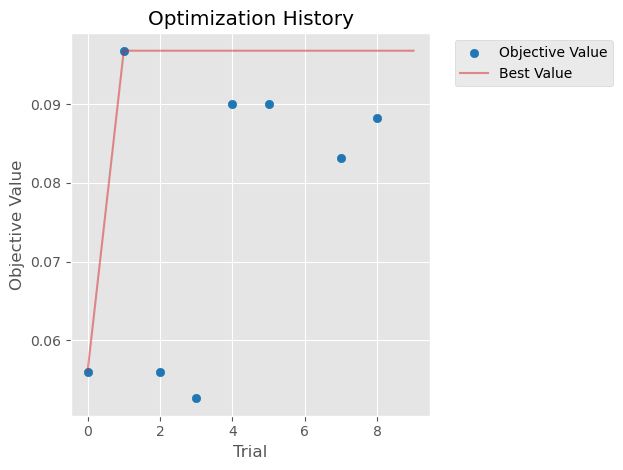

/var/folders/r5/_05_w2k14p728pkkf57ysjg40000gn/T/ipykernel_29741/337494126.py:19: ExperimentalWarning:

optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



<Figure size 640x480 with 0 Axes>

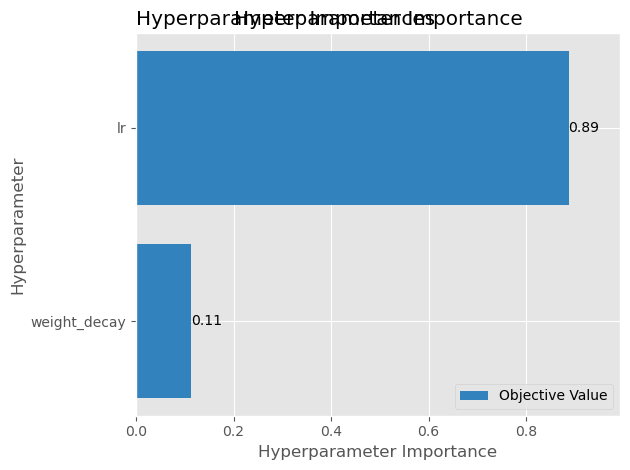

Plots saved successfully (or skipped if invalid).


In [ ]:
try:
    plt.figure()
    plot_optimization_history(study)
    plt.title("Optimization History")
    plt.tight_layout()
    plt.savefig("optuna_history.png")
    plt.show()
except Exception as e:
    print(f"Skipping history plot: {e}")

try:
    plt.figure()
    plot_param_importances(study)
    plt.title("Hyperparameter Importance")
    plt.tight_layout()
    plt.savefig("optuna_importance.png")
    plt.show()
except Exception as e:
    print(f"Skipping importance plot: {e}")

print("Plots saved successfully (or skipped if invalid).")

In [15]:
set_seed(42)

model = timm.create_model(
    MODEL_NAME, 
    pretrained=False, 
    num_classes=200 
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

class TimmTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.epoch_train_loss = 0.0
        self.epoch_train_acc = 0.0
        self.epoch_steps = 0

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        pixel_values = inputs.get("pixel_values")
        labels = inputs.get("labels")
        
        logits = model(pixel_values)
        loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(logits, labels)
        
        if model.training:
            with torch.no_grad():
                preds = torch.argmax(logits, dim=-1)
                acc = (preds == labels).float().mean().item()
                
                self.epoch_train_loss += loss.item()
                self.epoch_train_acc += acc
                self.epoch_steps += 1
                
                if self.epoch_steps % 20 == 0:
                    current_epoch_float = self.state.epoch if self.state.epoch is not None else 0
                    print(f" >> Epoch: {current_epoch_float:.2f} | Batch: {self.epoch_steps} | Curr Loss: {loss.item():.4f}")
        
        return (loss, logits) if return_outputs else loss
    
    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
        pixel_values = inputs.get("pixel_values")
        labels = inputs.get("labels")
        with torch.no_grad():
            logits = model(pixel_values)
        loss = None
        if labels is not None:
            loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
        if prediction_loss_only:
            return (loss, None, None)
        return (loss, logits, labels)

    def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval"):
        metrics = super().evaluate(eval_dataset, ignore_keys, metric_key_prefix)
        
        avg_train_loss = self.epoch_train_loss / self.epoch_steps if self.epoch_steps > 0 else 0
        avg_train_acc = self.epoch_train_acc / self.epoch_steps if self.epoch_steps > 0 else 0
        
        val_loss = metrics.get(f"{metric_key_prefix}_loss", 0.0)
        val_acc = metrics.get(f"{metric_key_prefix}_accuracy", 0.0)
        
        epoch_num = int(self.state.epoch) if self.state.epoch else 0
        
        print("\n" + "="*80)
        print(f" Training Loss:   {avg_train_loss:.4f} | Training Acc:   {avg_train_acc*100:.2f}%")
        print(f" Validation Loss: {val_loss:.4f}       | Validation Acc: {val_acc*100:.2f}%")
        print("="*80 + "\n")
        
        # resetting counters
        self.epoch_train_loss = 0.0
        self.epoch_train_acc = 0.0
        self.epoch_steps = 0
        
        return metrics

# accuracy metrics:
accuracy = evaluate.load("accuracy")

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return accuracy.compute(predictions=preds, references=p.label_ids)

# training, updated from Optuna
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=32, 
    num_train_epochs=30,
    learning_rate=5.9e-4,
    weight_decay=0.065,
    warmup_ratio=0.1,
    
    load_best_model_at_end=True,     
    metric_for_best_model="accuracy",
    save_total_limit=1,
    seed=42,
    
    disable_tqdm=True, # for now bc i dont like it - Julia
    
    logging_strategy="epoch", 
    save_strategy="epoch",
    eval_strategy="epoch",
    
    dataloader_num_workers=0,
    remove_unused_columns=False,
    report_to="none"
)

# the actual training
trainer = TimmTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    compute_metrics=compute_metrics,
)

trainer.train()

trainer.save_model("final_new_model")
print("Best model saved.")

/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.



 >> Epoch: 0.18 | Batch: 20 | Curr Loss: 5.3773
 >> Epoch: 0.37 | Batch: 40 | Curr Loss: 5.3805
 >> Epoch: 0.56 | Batch: 60 | Curr Loss: 5.2839
 >> Epoch: 0.75 | Batch: 80 | Curr Loss: 5.1462
 >> Epoch: 0.94 | Batch: 100 | Curr Loss: 4.9136
{'loss': 5.2178, 'grad_norm': 10.284223556518555, 'learning_rate': 0.0001947936507936508, 'epoch': 1.0}
{'eval_loss': 5.130096912384033, 'eval_accuracy': 0.013582342954159592, 'eval_runtime': 51.2801, 'eval_samples_per_second': 11.486, 'eval_steps_per_second': 1.443, 'epoch': 1.0}

 Training Loss:   5.2178 | Training Acc:   2.11%
 Validation Loss: 5.1301       | Validation Acc: 1.36%



/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.



 >> Epoch: 1.18 | Batch: 20 | Curr Loss: 4.9328
 >> Epoch: 1.37 | Batch: 40 | Curr Loss: 4.8964
 >> Epoch: 1.56 | Batch: 60 | Curr Loss: 5.1237
 >> Epoch: 1.75 | Batch: 80 | Curr Loss: 4.8773
 >> Epoch: 1.94 | Batch: 100 | Curr Loss: 5.0080
{'loss': 4.9839, 'grad_norm': 8.275290489196777, 'learning_rate': 0.00039146031746031747, 'epoch': 2.0}
{'eval_loss': 4.927040100097656, 'eval_accuracy': 0.027164685908319185, 'eval_runtime': 51.1794, 'eval_samples_per_second': 11.509, 'eval_steps_per_second': 1.446, 'epoch': 2.0}

 Training Loss:   4.9839 | Training Acc:   2.47%
 Validation Loss: 4.9270       | Validation Acc: 2.72%



/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.



 >> Epoch: 2.18 | Batch: 20 | Curr Loss: 4.8494
 >> Epoch: 2.37 | Batch: 40 | Curr Loss: 4.7197
 >> Epoch: 2.56 | Batch: 60 | Curr Loss: 4.9131
 >> Epoch: 2.75 | Batch: 80 | Curr Loss: 4.5204
 >> Epoch: 2.94 | Batch: 100 | Curr Loss: 4.3287
{'loss': 4.754, 'grad_norm': 10.03862476348877, 'learning_rate': 0.0005881269841269841, 'epoch': 3.0}
{'eval_loss': 4.844227313995361, 'eval_accuracy': 0.03395585738539898, 'eval_runtime': 50.5502, 'eval_samples_per_second': 11.652, 'eval_steps_per_second': 1.464, 'epoch': 3.0}

 Training Loss:   4.7540 | Training Acc:   4.49%
 Validation Loss: 4.8442       | Validation Acc: 3.40%



/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.



 >> Epoch: 3.18 | Batch: 20 | Curr Loss: 4.1451
 >> Epoch: 3.37 | Batch: 40 | Curr Loss: 4.2590
 >> Epoch: 3.56 | Batch: 60 | Curr Loss: 4.1918
 >> Epoch: 3.75 | Batch: 80 | Curr Loss: 4.5747
 >> Epoch: 3.94 | Batch: 100 | Curr Loss: 3.8969
{'loss': 4.3823, 'grad_norm': 8.395546913146973, 'learning_rate': 0.0005683562610229277, 'epoch': 4.0}
{'eval_loss': 4.422349452972412, 'eval_accuracy': 0.06112054329371817, 'eval_runtime': 50.0191, 'eval_samples_per_second': 11.776, 'eval_steps_per_second': 1.479, 'epoch': 4.0}

 Training Loss:   4.3823 | Training Acc:   7.08%
 Validation Loss: 4.4223       | Validation Acc: 6.11%



/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.



 >> Epoch: 4.18 | Batch: 20 | Curr Loss: 3.8817
 >> Epoch: 4.37 | Batch: 40 | Curr Loss: 3.8333
 >> Epoch: 4.56 | Batch: 60 | Curr Loss: 3.9109
 >> Epoch: 4.75 | Batch: 80 | Curr Loss: 4.1220
 >> Epoch: 4.94 | Batch: 100 | Curr Loss: 3.9872
{'loss': 3.9773, 'grad_norm': 8.08813190460205, 'learning_rate': 0.0005465044091710759, 'epoch': 5.0}
{'eval_loss': 4.1935577392578125, 'eval_accuracy': 0.07640067911714771, 'eval_runtime': 50.5166, 'eval_samples_per_second': 11.66, 'eval_steps_per_second': 1.465, 'epoch': 5.0}

 Training Loss:   3.9773 | Training Acc:   10.97%
 Validation Loss: 4.1936       | Validation Acc: 7.64%



/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.



 >> Epoch: 5.18 | Batch: 20 | Curr Loss: 3.4830
 >> Epoch: 5.37 | Batch: 40 | Curr Loss: 3.6370
 >> Epoch: 5.56 | Batch: 60 | Curr Loss: 4.1356
 >> Epoch: 5.75 | Batch: 80 | Curr Loss: 4.0558
 >> Epoch: 5.94 | Batch: 100 | Curr Loss: 3.3267
{'loss': 3.622, 'grad_norm': 10.726155281066895, 'learning_rate': 0.000524652557319224, 'epoch': 6.0}
{'eval_loss': 4.050048828125, 'eval_accuracy': 0.10865874363327674, 'eval_runtime': 39.7396, 'eval_samples_per_second': 14.821, 'eval_steps_per_second': 1.862, 'epoch': 6.0}

 Training Loss:   3.6220 | Training Acc:   16.55%
 Validation Loss: 4.0500       | Validation Acc: 10.87%



/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.



 >> Epoch: 6.18 | Batch: 20 | Curr Loss: 3.1074
 >> Epoch: 6.37 | Batch: 40 | Curr Loss: 3.4686
 >> Epoch: 6.56 | Batch: 60 | Curr Loss: 3.1930
 >> Epoch: 6.75 | Batch: 80 | Curr Loss: 3.4166
 >> Epoch: 6.94 | Batch: 100 | Curr Loss: 2.7455
{'loss': 3.3184, 'grad_norm': 14.633980751037598, 'learning_rate': 0.0005028007054673722, 'epoch': 7.0}
{'eval_loss': 3.945162773132324, 'eval_accuracy': 0.12224108658743633, 'eval_runtime': 40.5142, 'eval_samples_per_second': 14.538, 'eval_steps_per_second': 1.827, 'epoch': 7.0}

 Training Loss:   3.3184 | Training Acc:   20.14%
 Validation Loss: 3.9452       | Validation Acc: 12.22%



/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.



 >> Epoch: 7.18 | Batch: 20 | Curr Loss: 2.7180
 >> Epoch: 7.37 | Batch: 40 | Curr Loss: 3.5422
 >> Epoch: 7.56 | Batch: 60 | Curr Loss: 3.5168
 >> Epoch: 7.75 | Batch: 80 | Curr Loss: 2.7648
 >> Epoch: 7.94 | Batch: 100 | Curr Loss: 2.7176
{'loss': 3.0321, 'grad_norm': 9.29461669921875, 'learning_rate': 0.00048094885361552026, 'epoch': 8.0}
{'eval_loss': 3.838784694671631, 'eval_accuracy': 0.1307300509337861, 'eval_runtime': 40.1665, 'eval_samples_per_second': 14.664, 'eval_steps_per_second': 1.842, 'epoch': 8.0}

 Training Loss:   3.0321 | Training Acc:   25.35%
 Validation Loss: 3.8388       | Validation Acc: 13.07%



/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.



 >> Epoch: 8.18 | Batch: 20 | Curr Loss: 2.7043
 >> Epoch: 8.37 | Batch: 40 | Curr Loss: 2.5600
 >> Epoch: 8.56 | Batch: 60 | Curr Loss: 3.0015
 >> Epoch: 8.75 | Batch: 80 | Curr Loss: 2.8091
 >> Epoch: 8.94 | Batch: 100 | Curr Loss: 2.7317
{'loss': 2.7037, 'grad_norm': 12.002574920654297, 'learning_rate': 0.0004590970017636685, 'epoch': 9.0}
{'eval_loss': 3.8045663833618164, 'eval_accuracy': 0.15789473684210525, 'eval_runtime': 40.0145, 'eval_samples_per_second': 14.72, 'eval_steps_per_second': 1.849, 'epoch': 9.0}

 Training Loss:   2.7037 | Training Acc:   31.33%
 Validation Loss: 3.8046       | Validation Acc: 15.79%



/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.



 >> Epoch: 9.18 | Batch: 20 | Curr Loss: 3.0540
 >> Epoch: 9.37 | Batch: 40 | Curr Loss: 2.0197
 >> Epoch: 9.56 | Batch: 60 | Curr Loss: 2.6784
 >> Epoch: 9.75 | Batch: 80 | Curr Loss: 2.1509
 >> Epoch: 9.94 | Batch: 100 | Curr Loss: 2.6214
{'loss': 2.4116, 'grad_norm': 15.873795509338379, 'learning_rate': 0.0004372451499118166, 'epoch': 10.0}
{'eval_loss': 3.768836498260498, 'eval_accuracy': 0.15789473684210525, 'eval_runtime': 39.7963, 'eval_samples_per_second': 14.8, 'eval_steps_per_second': 1.859, 'epoch': 10.0}

 Training Loss:   2.4116 | Training Acc:   36.45%
 Validation Loss: 3.7688       | Validation Acc: 15.79%



/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.



 >> Epoch: 10.18 | Batch: 20 | Curr Loss: 2.1130
 >> Epoch: 10.37 | Batch: 40 | Curr Loss: 1.9455
 >> Epoch: 10.56 | Batch: 60 | Curr Loss: 1.8883
 >> Epoch: 10.75 | Batch: 80 | Curr Loss: 1.9698
 >> Epoch: 10.94 | Batch: 100 | Curr Loss: 1.8928
{'loss': 2.0707, 'grad_norm': 11.393025398254395, 'learning_rate': 0.00041539329805996474, 'epoch': 11.0}
{'eval_loss': 3.6934709548950195, 'eval_accuracy': 0.19524617996604415, 'eval_runtime': 40.2741, 'eval_samples_per_second': 14.625, 'eval_steps_per_second': 1.837, 'epoch': 11.0}

 Training Loss:   2.0707 | Training Acc:   45.07%
 Validation Loss: 3.6935       | Validation Acc: 19.52%



/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.



 >> Epoch: 11.18 | Batch: 20 | Curr Loss: 1.5515
 >> Epoch: 11.37 | Batch: 40 | Curr Loss: 1.8391
 >> Epoch: 11.56 | Batch: 60 | Curr Loss: 2.0574
 >> Epoch: 11.75 | Batch: 80 | Curr Loss: 2.0720
 >> Epoch: 11.94 | Batch: 100 | Curr Loss: 1.8555
{'loss': 1.7389, 'grad_norm': 16.961502075195312, 'learning_rate': 0.0003935414462081129, 'epoch': 12.0}
{'eval_loss': 3.720306873321533, 'eval_accuracy': 0.19185059422750425, 'eval_runtime': 40.0942, 'eval_samples_per_second': 14.69, 'eval_steps_per_second': 1.846, 'epoch': 12.0}

 Training Loss:   1.7389 | Training Acc:   52.71%
 Validation Loss: 3.7203       | Validation Acc: 19.19%



/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.



 >> Epoch: 12.18 | Batch: 20 | Curr Loss: 1.3650
 >> Epoch: 12.37 | Batch: 40 | Curr Loss: 1.2278
 >> Epoch: 12.56 | Batch: 60 | Curr Loss: 1.4190
 >> Epoch: 12.75 | Batch: 80 | Curr Loss: 1.4284
 >> Epoch: 12.94 | Batch: 100 | Curr Loss: 1.5411
{'loss': 1.4315, 'grad_norm': 22.982240676879883, 'learning_rate': 0.00037168959435626106, 'epoch': 13.0}
{'eval_loss': 3.8373732566833496, 'eval_accuracy': 0.21731748726655348, 'eval_runtime': 40.5991, 'eval_samples_per_second': 14.508, 'eval_steps_per_second': 1.823, 'epoch': 13.0}

 Training Loss:   1.4315 | Training Acc:   60.96%
 Validation Loss: 3.8374       | Validation Acc: 21.73%



/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.



 >> Epoch: 13.18 | Batch: 20 | Curr Loss: 0.6224
 >> Epoch: 13.37 | Batch: 40 | Curr Loss: 0.9201
 >> Epoch: 13.56 | Batch: 60 | Curr Loss: 1.2351
 >> Epoch: 13.75 | Batch: 80 | Curr Loss: 1.4629
 >> Epoch: 13.94 | Batch: 100 | Curr Loss: 1.2607
{'loss': 1.1369, 'grad_norm': 25.78968048095703, 'learning_rate': 0.00034983774250440917, 'epoch': 14.0}
{'eval_loss': 3.9683172702789307, 'eval_accuracy': 0.200339558573854, 'eval_runtime': 40.3588, 'eval_samples_per_second': 14.594, 'eval_steps_per_second': 1.834, 'epoch': 14.0}

 Training Loss:   1.1369 | Training Acc:   69.83%
 Validation Loss: 3.9683       | Validation Acc: 20.03%



/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.



 >> Epoch: 14.18 | Batch: 20 | Curr Loss: 0.8004
 >> Epoch: 14.37 | Batch: 40 | Curr Loss: 0.8045
 >> Epoch: 14.56 | Batch: 60 | Curr Loss: 0.6726
 >> Epoch: 14.75 | Batch: 80 | Curr Loss: 0.9072
 >> Epoch: 14.94 | Batch: 100 | Curr Loss: 0.8003
{'loss': 0.8623, 'grad_norm': 15.766268730163574, 'learning_rate': 0.00032798589065255733, 'epoch': 15.0}
{'eval_loss': 3.8935000896453857, 'eval_accuracy': 0.23938879456706283, 'eval_runtime': 40.6202, 'eval_samples_per_second': 14.5, 'eval_steps_per_second': 1.822, 'epoch': 15.0}

 Training Loss:   0.8623 | Training Acc:   77.63%
 Validation Loss: 3.8935       | Validation Acc: 23.94%



/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.



 >> Epoch: 15.18 | Batch: 20 | Curr Loss: 0.5203
 >> Epoch: 15.37 | Batch: 40 | Curr Loss: 0.4531
 >> Epoch: 15.56 | Batch: 60 | Curr Loss: 0.9423
 >> Epoch: 15.75 | Batch: 80 | Curr Loss: 1.0892
 >> Epoch: 15.94 | Batch: 100 | Curr Loss: 0.5968
{'loss': 0.65, 'grad_norm': 45.053955078125, 'learning_rate': 0.0003061340388007055, 'epoch': 16.0}
{'eval_loss': 4.2083635330200195, 'eval_accuracy': 0.1969439728353141, 'eval_runtime': 38.9639, 'eval_samples_per_second': 15.117, 'eval_steps_per_second': 1.899, 'epoch': 16.0}

 Training Loss:   0.6500 | Training Acc:   83.86%
 Validation Loss: 4.2084       | Validation Acc: 19.69%



/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.



 >> Epoch: 16.18 | Batch: 20 | Curr Loss: 0.3888
 >> Epoch: 16.37 | Batch: 40 | Curr Loss: 0.2316
 >> Epoch: 16.56 | Batch: 60 | Curr Loss: 0.6525
 >> Epoch: 16.75 | Batch: 80 | Curr Loss: 0.6945
 >> Epoch: 16.94 | Batch: 100 | Curr Loss: 0.7494
{'loss': 0.4624, 'grad_norm': 11.883749008178711, 'learning_rate': 0.0002842821869488536, 'epoch': 17.0}
{'eval_loss': 4.194108009338379, 'eval_accuracy': 0.22071307300509338, 'eval_runtime': 38.7248, 'eval_samples_per_second': 15.21, 'eval_steps_per_second': 1.911, 'epoch': 17.0}

 Training Loss:   0.4624 | Training Acc:   89.64%
 Validation Loss: 4.1941       | Validation Acc: 22.07%



/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.



 >> Epoch: 17.18 | Batch: 20 | Curr Loss: 0.3237
 >> Epoch: 17.37 | Batch: 40 | Curr Loss: 0.3824
 >> Epoch: 17.56 | Batch: 60 | Curr Loss: 0.2998
 >> Epoch: 17.75 | Batch: 80 | Curr Loss: 0.1627
 >> Epoch: 17.94 | Batch: 100 | Curr Loss: 0.3493
{'loss': 0.3135, 'grad_norm': 14.126153945922852, 'learning_rate': 0.00026243033509700176, 'epoch': 18.0}
{'eval_loss': 4.239490032196045, 'eval_accuracy': 0.21731748726655348, 'eval_runtime': 39.3812, 'eval_samples_per_second': 14.956, 'eval_steps_per_second': 1.879, 'epoch': 18.0}

 Training Loss:   0.3135 | Training Acc:   93.84%
 Validation Loss: 4.2395       | Validation Acc: 21.73%



/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.



 >> Epoch: 18.18 | Batch: 20 | Curr Loss: 0.1911
 >> Epoch: 18.37 | Batch: 40 | Curr Loss: 0.1680
 >> Epoch: 18.56 | Batch: 60 | Curr Loss: 0.1914
 >> Epoch: 18.75 | Batch: 80 | Curr Loss: 0.1563
 >> Epoch: 18.94 | Batch: 100 | Curr Loss: 0.1801
{'loss': 0.219, 'grad_norm': 6.319021701812744, 'learning_rate': 0.00024057848324514992, 'epoch': 19.0}
{'eval_loss': 4.304888725280762, 'eval_accuracy': 0.22750424448217318, 'eval_runtime': 40.7165, 'eval_samples_per_second': 14.466, 'eval_steps_per_second': 1.817, 'epoch': 19.0}

 Training Loss:   0.2190 | Training Acc:   96.49%
 Validation Loss: 4.3049       | Validation Acc: 22.75%



/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.



 >> Epoch: 19.18 | Batch: 20 | Curr Loss: 0.1677
 >> Epoch: 19.37 | Batch: 40 | Curr Loss: 0.1382
 >> Epoch: 19.56 | Batch: 60 | Curr Loss: 0.1251
 >> Epoch: 19.75 | Batch: 80 | Curr Loss: 0.2452
 >> Epoch: 19.94 | Batch: 100 | Curr Loss: 0.2391
{'loss': 0.163, 'grad_norm': 11.006569862365723, 'learning_rate': 0.00021872663139329806, 'epoch': 20.0}
{'eval_loss': 4.4433112144470215, 'eval_accuracy': 0.23599320882852293, 'eval_runtime': 38.9619, 'eval_samples_per_second': 15.117, 'eval_steps_per_second': 1.899, 'epoch': 20.0}

 Training Loss:   0.1630 | Training Acc:   97.35%
 Validation Loss: 4.4433       | Validation Acc: 23.60%



/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.



 >> Epoch: 20.18 | Batch: 20 | Curr Loss: 0.0818
 >> Epoch: 20.37 | Batch: 40 | Curr Loss: 0.1103
 >> Epoch: 20.56 | Batch: 60 | Curr Loss: 0.1260
 >> Epoch: 20.75 | Batch: 80 | Curr Loss: 0.1257
 >> Epoch: 20.94 | Batch: 100 | Curr Loss: 0.1480
{'loss': 0.1056, 'grad_norm': 4.885464668273926, 'learning_rate': 0.00019687477954144622, 'epoch': 21.0}
{'eval_loss': 4.59205961227417, 'eval_accuracy': 0.21731748726655348, 'eval_runtime': 40.2525, 'eval_samples_per_second': 14.633, 'eval_steps_per_second': 1.838, 'epoch': 21.0}

 Training Loss:   0.1056 | Training Acc:   98.51%
 Validation Loss: 4.5921       | Validation Acc: 21.73%



/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.



 >> Epoch: 21.18 | Batch: 20 | Curr Loss: 0.0576
 >> Epoch: 21.37 | Batch: 40 | Curr Loss: 0.0737
 >> Epoch: 21.56 | Batch: 60 | Curr Loss: 0.0560
 >> Epoch: 21.75 | Batch: 80 | Curr Loss: 0.0348
 >> Epoch: 21.94 | Batch: 100 | Curr Loss: 0.0772
{'loss': 0.0735, 'grad_norm': 36.170257568359375, 'learning_rate': 0.00017502292768959435, 'epoch': 22.0}
{'eval_loss': 4.522821426391602, 'eval_accuracy': 0.23089983022071306, 'eval_runtime': 38.8417, 'eval_samples_per_second': 15.164, 'eval_steps_per_second': 1.905, 'epoch': 22.0}

 Training Loss:   0.0735 | Training Acc:   99.15%
 Validation Loss: 4.5228       | Validation Acc: 23.09%



/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.



 >> Epoch: 22.18 | Batch: 20 | Curr Loss: 0.0395
 >> Epoch: 22.37 | Batch: 40 | Curr Loss: 0.0300
 >> Epoch: 22.56 | Batch: 60 | Curr Loss: 0.0474
 >> Epoch: 22.75 | Batch: 80 | Curr Loss: 0.0203
 >> Epoch: 22.94 | Batch: 100 | Curr Loss: 0.0610
{'loss': 0.0467, 'grad_norm': 7.824173450469971, 'learning_rate': 0.0001531710758377425, 'epoch': 23.0}
{'eval_loss': 4.717574596405029, 'eval_accuracy': 0.24448217317487267, 'eval_runtime': 38.8327, 'eval_samples_per_second': 15.168, 'eval_steps_per_second': 1.906, 'epoch': 23.0}

 Training Loss:   0.0467 | Training Acc:   99.35%
 Validation Loss: 4.7176       | Validation Acc: 24.45%



/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.



 >> Epoch: 23.18 | Batch: 20 | Curr Loss: 0.0132
 >> Epoch: 23.37 | Batch: 40 | Curr Loss: 0.0181
 >> Epoch: 23.56 | Batch: 60 | Curr Loss: 0.0580
 >> Epoch: 23.75 | Batch: 80 | Curr Loss: 0.0455
 >> Epoch: 23.94 | Batch: 100 | Curr Loss: 0.0194
{'loss': 0.0277, 'grad_norm': 2.1753718852996826, 'learning_rate': 0.00013131922398589065, 'epoch': 24.0}
{'eval_loss': 4.52877140045166, 'eval_accuracy': 0.24448217317487267, 'eval_runtime': 38.5163, 'eval_samples_per_second': 15.292, 'eval_steps_per_second': 1.921, 'epoch': 24.0}

 Training Loss:   0.0277 | Training Acc:   99.70%
 Validation Loss: 4.5288       | Validation Acc: 24.45%



/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.



 >> Epoch: 24.18 | Batch: 20 | Curr Loss: 0.0051
 >> Epoch: 24.37 | Batch: 40 | Curr Loss: 0.0274
 >> Epoch: 24.56 | Batch: 60 | Curr Loss: 0.0064
 >> Epoch: 24.75 | Batch: 80 | Curr Loss: 0.0106
 >> Epoch: 24.94 | Batch: 100 | Curr Loss: 0.0209
{'loss': 0.0122, 'grad_norm': 0.6602526307106018, 'learning_rate': 0.00010946737213403881, 'epoch': 25.0}
{'eval_loss': 4.658316612243652, 'eval_accuracy': 0.26485568760611206, 'eval_runtime': 39.1368, 'eval_samples_per_second': 15.05, 'eval_steps_per_second': 1.891, 'epoch': 25.0}

 Training Loss:   0.0122 | Training Acc:   99.88%
 Validation Loss: 4.6583       | Validation Acc: 26.49%



/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.



 >> Epoch: 25.18 | Batch: 20 | Curr Loss: 0.0062
 >> Epoch: 25.37 | Batch: 40 | Curr Loss: 0.0092
 >> Epoch: 25.56 | Batch: 60 | Curr Loss: 0.0040
 >> Epoch: 25.75 | Batch: 80 | Curr Loss: 0.0040
 >> Epoch: 25.94 | Batch: 100 | Curr Loss: 0.0065
{'loss': 0.0058, 'grad_norm': 3.255305767059326, 'learning_rate': 8.761552028218696e-05, 'epoch': 26.0}
{'eval_loss': 4.678788661956787, 'eval_accuracy': 0.266553480475382, 'eval_runtime': 38.8178, 'eval_samples_per_second': 15.173, 'eval_steps_per_second': 1.906, 'epoch': 26.0}

 Training Loss:   0.0058 | Training Acc:   100.00%
 Validation Loss: 4.6788       | Validation Acc: 26.66%



/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.



 >> Epoch: 26.18 | Batch: 20 | Curr Loss: 0.0025
 >> Epoch: 26.37 | Batch: 40 | Curr Loss: 0.0039
 >> Epoch: 26.56 | Batch: 60 | Curr Loss: 0.0032
 >> Epoch: 26.75 | Batch: 80 | Curr Loss: 0.0054
 >> Epoch: 26.94 | Batch: 100 | Curr Loss: 0.0028
{'loss': 0.0042, 'grad_norm': 0.3624430298805237, 'learning_rate': 6.57636684303351e-05, 'epoch': 27.0}
{'eval_loss': 4.6009416580200195, 'eval_accuracy': 0.2529711375212224, 'eval_runtime': 38.7161, 'eval_samples_per_second': 15.213, 'eval_steps_per_second': 1.911, 'epoch': 27.0}

 Training Loss:   0.0042 | Training Acc:   100.00%
 Validation Loss: 4.6009       | Validation Acc: 25.30%



/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.



 >> Epoch: 27.18 | Batch: 20 | Curr Loss: 0.0021
 >> Epoch: 27.37 | Batch: 40 | Curr Loss: 0.0053
 >> Epoch: 27.56 | Batch: 60 | Curr Loss: 0.0037
 >> Epoch: 27.75 | Batch: 80 | Curr Loss: 0.0015
 >> Epoch: 27.94 | Batch: 100 | Curr Loss: 0.0022
{'loss': 0.0035, 'grad_norm': 0.3796064555644989, 'learning_rate': 4.3911816578483244e-05, 'epoch': 28.0}
{'eval_loss': 4.644228458404541, 'eval_accuracy': 0.2699490662139219, 'eval_runtime': 39.1944, 'eval_samples_per_second': 15.028, 'eval_steps_per_second': 1.888, 'epoch': 28.0}

 Training Loss:   0.0035 | Training Acc:   100.00%
 Validation Loss: 4.6442       | Validation Acc: 26.99%



/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.



 >> Epoch: 28.18 | Batch: 20 | Curr Loss: 0.0023
 >> Epoch: 28.37 | Batch: 40 | Curr Loss: 0.0017
 >> Epoch: 28.56 | Batch: 60 | Curr Loss: 0.0027
 >> Epoch: 28.75 | Batch: 80 | Curr Loss: 0.0030
 >> Epoch: 28.94 | Batch: 100 | Curr Loss: 0.0015
{'loss': 0.0026, 'grad_norm': 0.7686575055122375, 'learning_rate': 2.2059964726631395e-05, 'epoch': 29.0}
{'eval_loss': 4.679091453552246, 'eval_accuracy': 0.2699490662139219, 'eval_runtime': 39.1696, 'eval_samples_per_second': 15.037, 'eval_steps_per_second': 1.889, 'epoch': 29.0}

 Training Loss:   0.0026 | Training Acc:   100.00%
 Validation Loss: 4.6791       | Validation Acc: 26.99%



/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.



 >> Epoch: 29.18 | Batch: 20 | Curr Loss: 0.0011
 >> Epoch: 29.37 | Batch: 40 | Curr Loss: 0.0011
 >> Epoch: 29.56 | Batch: 60 | Curr Loss: 0.0030
 >> Epoch: 29.75 | Batch: 80 | Curr Loss: 0.0013
 >> Epoch: 29.94 | Batch: 100 | Curr Loss: 0.0020
{'loss': 0.0046, 'grad_norm': 16.601381301879883, 'learning_rate': 2.0811287477954147e-07, 'epoch': 30.0}
{'eval_loss': 4.657985210418701, 'eval_accuracy': 0.2699490662139219, 'eval_runtime': 39.2359, 'eval_samples_per_second': 15.012, 'eval_steps_per_second': 1.886, 'epoch': 30.0}

 Training Loss:   0.0046 | Training Acc:   99.89%
 Validation Loss: 4.6580       | Validation Acc: 26.99%

{'train_runtime': 10929.6477, 'train_samples_per_second': 9.159, 'train_steps_per_second': 0.288, 'train_loss': 1.5912546919830262, 'epoch': 30.0}
Best model saved.


In [18]:
import safetensors.torch

# check the accuracy of the model we just saved (seed 42) to know what to beat
print("Loading previous best model to establish baseline.")
model = timm.create_model(MODEL_NAME, pretrained=False, num_classes=200)

try:
    state_dict = safetensors.torch.load_file("final_new_model/model.safetensors", device=device)
except FileNotFoundError:
    state_dict = safetensors.torch.load_file(f"{OUTPUT_DIR}/final_new_model/model.safetensors", device=device)

model.load_state_dict(state_dict)
model.to(device)

# simple trainer just for evaluation
eval_trainer = TimmTrainer(
    model=model,
    args=TrainingArguments(output_dir="temp_eval", report_to="none", per_device_eval_batch_size=32),
    eval_dataset=dataset["validation"],
    compute_metrics=compute_metrics
)
base_metrics = eval_trainer.evaluate()
global_best_acc = base_metrics["eval_accuracy"]
print(f"Current Best Accuracy (Seed 42): {global_best_acc*100:.2f}%")

# now run the other seeds
other_seeds = [1, 100]

for seed in other_seeds:
    print(f"\n{'='*20} Running Seed {seed} {'='*20}")
    set_seed(seed)

    model = timm.create_model(
        MODEL_NAME, 
        pretrained=False, 
        num_classes=200 
    )
    model.to(device)
    
    # same args as before
    training_args = TrainingArguments(
        output_dir=f"{OUTPUT_DIR}/seed_{seed}",
        per_device_train_batch_size=32, 
        num_train_epochs=30,
        learning_rate=5.9e-4,     
        weight_decay=0.065,       
        warmup_ratio=0.1,
        
        load_best_model_at_end=True,     
        metric_for_best_model="accuracy",
        save_total_limit=1,
        seed=seed,
        
        disable_tqdm=True,
        logging_strategy="epoch", 
        save_strategy="epoch",
        eval_strategy="epoch",
        
        dataloader_num_workers=0,
        remove_unused_columns=False,
        report_to="none"
    )

    trainer = TimmTrainer(
        model=model,
        args=training_args,
        train_dataset=dataset["train"],
        eval_dataset=dataset["validation"],
        compute_metrics=compute_metrics,
    )

    trainer.train()
    
    # check if this seed beat the previous best
    metrics = trainer.evaluate()
    current_acc = metrics["eval_accuracy"]
    print(f"Seed {seed} Accuracy: {current_acc*100:.2f}%")
    
    if current_acc > global_best_acc:
        print(f"New best found! ({current_acc*100:.2f}% > {global_best_acc*100:.2f}%) Overwriting final model...")
        global_best_acc = current_acc
        trainer.save_model("final_new_model") # Saves the new best model
    else:
        print(f"Did not beat current best ({global_best_acc*100:.2f}%). Keeping previous model.")

print(f"Final Experiment Finished. Best model saved with accuracy: {global_best_acc*100:.2f}%")

Loading previous best model to establish baseline.


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.



TypeError: conv2d() received an invalid combination of arguments - got (NoneType, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!NoneType!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!NoneType!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
